<a href="https://colab.research.google.com/github/C4puto/IFMG_arquivos_atividades/blob/main/Modified_Evolving_Clustering_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evolving Clustering

In [1]:
import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

import math
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import itertools as it
from numba import jit


class EvolvingClustering:
    def __init__(self, macro_cluster_update=1,
                 verbose=0, variance_limit=0.001, decay = 100, debug=False, plot_graph=False):
        self.verbose = verbose
        self.total_num_samples = 0
        self.micro_clusters = []
        self.macro_clusters = []
        self.active_macro_clusters = []
        self.graph = nx.Graph()
        self.active_graph = nx.Graph()
        self.variance_limit = variance_limit
        self.macro_cluster_update = macro_cluster_update
        self.debug = debug
        self.plot_graph = plot_graph
        self.changed_micro_clusters = []
        self.fading_factor = 1 / decay

    @staticmethod
    def get_micro_cluster(id, num_samples, mean, variance, density, life):
        return {"id": id,"num_samples": num_samples, "mean": mean, "variance": variance,
                "density": density, "active": True, "changed": True, "life": life}

    def create_new_micro_cluster(self, x):

        if len(self.micro_clusters) == 0:
            id = 1
        else:
            id = max([m["id"] for m in self.micro_clusters]) + 1

        num_samples = 1
        mean = x
        variance = 0
        density = 0
        life = 1
        new_mc = EvolvingClustering.get_micro_cluster(id, num_samples, mean, variance, density, life)
        self.micro_clusters.append(new_mc)
        self.changed_micro_clusters.append(new_mc)
        self.graph.add_node(id)

    def is_outlier(self, s_ik, var_ik, norm_ecc):

        if s_ik < 3:
            outlier = (var_ik > self.variance_limit)
        else:
            mik_sik = 3 / (1 + math.exp(-0.007 * (s_ik - 100)))
            outlier_limit = ((mik_sik ** 2) + 1) / (2 * s_ik)
            outlier = (norm_ecc > outlier_limit)

        return outlier

    def update_micro_cluster(self, xk, micro_cluster, num_samples, mean, variance, norm_ecc):

        self.update_life(xk, micro_cluster)

        micro_cluster["num_samples"] = num_samples
        micro_cluster["mean"] = mean
        micro_cluster["variance"] = variance
        micro_cluster["density"] = 1 / norm_ecc
        micro_cluster["changed"] = True

        if micro_cluster not in self.changed_micro_clusters:
            self.changed_micro_clusters.append(micro_cluster)

    def update_life(self, xk, micro_cluster):
        previous_mean = micro_cluster["mean"]
        previous_var = micro_cluster["variance"]
        if previous_var > 0:
            d = EvolvingClustering.get_euclidean_distance(xk, previous_mean)
            dist = np.sqrt(np.sum(d))
            rt = np.sqrt(previous_var)
            micro_cluster["life"] = micro_cluster["life"] + (((rt - dist) / rt) * self.fading_factor)
        else:
            micro_cluster["life"] = 1

    @staticmethod
    def get_updated_micro_cluster_values(x, s_ik, mu_ik, var_ik):

        s_ik += 1
        mean = ((s_ik - 1) / s_ik) * mu_ik + (x / s_ik)

        # Codigo dissertacao
        delta = x - mean
        variance = EvolvingClustering.update_variance(delta, s_ik, var_ik)

        norm_ecc = EvolvingClustering.get_normalized_eccentricity(x, s_ik, mean, variance)
        return (s_ik, mean, variance, norm_ecc)

    @staticmethod
    @jit(nopython=True)
    def update_variance(delta, s_ik, var_ik):
        variance = ((s_ik - 1) / s_ik) * var_ik + (((np.linalg.norm(delta) * 2 / len(delta))** 2 / (s_ik - 1)))
        return variance

    @staticmethod
    def get_normalized_eccentricity(x, num_samples, mean, var):
        ecc = EvolvingClustering.get_eccentricity(x, num_samples, mean, var)
        return ecc / 2

    @staticmethod
    @jit(nopython=True)
    def get_eccentricity(x, num_samples, mean, var):
        if var == 0 and num_samples > 1:
            result = (1/num_samples)
        else:
            a = mean - x
            result = ((1 / num_samples) + ((np.linalg.norm(a) * 2 / len(a)) ** 2 / (num_samples * var)))

        return result

    def fit(self, X, update_macro_clusters=True, prune_micro_clusters=True):

        lenx = len(X)

        if self.debug:
            print("Training...")

        for xk in X:
            self.update_micro_clusters(xk)

            if prune_micro_clusters:
                self.prune_micro_clusters()

            self.total_num_samples += 1

            if self.debug:
                print('Training %d of %d' %(self.total_num_samples, lenx))

        if update_macro_clusters:
            if self.debug:
                print('Updating Macro_clusters')
            self.update_macro_clusters()

        if self.plot_graph:
            self.plot_micro_clusters(X)


    def update_micro_clusters(self, xk):
        # First sample
        if self.total_num_samples == 0:
            self.create_new_micro_cluster(xk)
        else:
            new_micro_cluster = True

            for mi in self.micro_clusters:
                mi["changed"] = False
                s_ik = mi["num_samples"]
                mu_ik = mi["mean"]
                var_ik = mi["variance"]

                (num_samples, mean, variance, norm_ecc) = EvolvingClustering.get_updated_micro_cluster_values(xk, s_ik, mu_ik, var_ik)

                if not self.is_outlier(num_samples, variance, norm_ecc):
                    self.update_micro_cluster(xk, mi, num_samples, mean, variance, norm_ecc)
                    new_micro_cluster = False

            if new_micro_cluster:
                self.create_new_micro_cluster(xk)

    def update_macro_clusters(self):
        self.define_macro_clusters()
        self.define_activations()

    def predict(self, X):
        self.labels_ = np.zeros(len(X), dtype=int)
        index = 0
        lenx = len(X)

        if self.debug:
            print('Predicting...')

        for xk in X:
            memberships = []
            for mg in self.active_macro_clusters:
                active_micro_clusters = self.get_active_micro_clusters(mg)

                memberships.append(EvolvingClustering.calculate_membership(xk, active_micro_clusters))

            self.labels_[index] = np.argmax(memberships)
            index += 1

            if self.debug:
                print('Predicting %d of %d' % (index, lenx))

        return self.labels_

    @staticmethod
    def calculate_membership(x, active_micro_clusters):
        total_density = 0
        for m in active_micro_clusters:
            total_density += m["density"]

        mb = 0
        for m in active_micro_clusters:
            d = m["density"]

            t = 1 - EvolvingClustering.get_normalized_eccentricity(x, m["num_samples"], m["mean"], m["variance"])
            mb += (d / total_density) * t
        return mb


    @staticmethod
    def calculate_micro_membership(x, params):

        micro_cluster = params[0]
        total_density = params[1]

        d = micro_cluster["density"]

        t = 1 - EvolvingClustering.get_normalized_eccentricity(x, micro_cluster["num_samples"], micro_cluster["mean"], micro_cluster["variance"])
        return (d / total_density) * t

    def get_total_density(self):
        active_mcs = self.get_all_active_micro_clusters()
        total_density = 0

        for m in active_mcs:
            total_density += m["density"]

        return total_density

    def get_active_micro_clusters(self, mg):
        active_micro_clusters = []
        for mi_ind in mg:
            mi = next(item for item in self.micro_clusters if item["id"] == mi_ind)
            if mi["active"]:
                active_micro_clusters.append(mi)
        return active_micro_clusters

    def get_all_active_micro_clusters(self):
        active_micro_clusters = []

        for m in self.micro_clusters:
            if m["active"]:
                active_micro_clusters.append(m)
        return active_micro_clusters

    def get_changed_micro_clusters(self):
        changed_micro_clusters = []

        for m in self.micro_clusters:
            if m["changed"]:
                changed_micro_clusters.append(m)
        return changed_micro_clusters

    def get_changed_active_micro_clusters(self):
        changed_micro_clusters = []

        for m in self.changed_micro_clusters:
            if m["active"]:
                changed_micro_clusters.append(m)
        return changed_micro_clusters


    def define_macro_clusters(self):

        for mi in self.changed_micro_clusters:
            for mj in self.micro_clusters:
                if mi["id"] != mj["id"]:
                    edge = (mi["id"],mj["id"])
                    if EvolvingClustering.has_intersection(mi, mj):
                        self.graph.add_edge(*edge)
                    elif EvolvingClustering.nodes_connected(mi["id"],mj["id"], self.graph):
                        self.graph.remove_edge(*edge)

        self.macro_clusters = list(nx.connected_components(self.graph))
        self.changed_micro_clusters.clear()



    @staticmethod
    def nodes_connected(u, v, G):
        return u in G.neighbors(v)

    def define_activations(self):

        self.active_graph = self.graph.copy()

        for mg in self.macro_clusters:
            num_micro = len(mg)
            total_density = 0

            for i in mg:
                dens = next(item["density"] for item in self.micro_clusters if item["id"] == i)
                total_density += dens

            mean_density = total_density / num_micro

            for i in mg:
                mi = next(item for item in self.micro_clusters if item["id"] == i)
                mi["active"] = (mi["num_samples"] > 2) and (mi["density"] >= mean_density)

                if not mi["active"]:
                    self.active_graph.remove_node(mi["id"])

        self.active_macro_clusters = list(nx.connected_components(self.active_graph))


    @staticmethod
    def has_intersection(mi, mj):
        mu_i = mi["mean"]
        mu_j = mj["mean"]
        var_i = mi["variance"]
        var_j = mj["variance"]

        d = EvolvingClustering.get_euclidean_distance(mu_i, mu_j)
        dist = np.sqrt(np.sum(d))

        deviation = EvolvingClustering.get_deviation(var_i, var_j)

        return dist <= deviation

    @staticmethod
    @jit(nopython=True)
    def get_deviation(var_i, var_j):
        deviation = 2 * (np.sqrt(var_i) + np.sqrt(var_j))
        return deviation

    @staticmethod
    @jit(nopython=True)
    def get_euclidean_distance(mu_i, mu_j):
        dist = [(a - b) ** 2 for a, b in zip(mu_i, mu_j)]
        return dist

    def plot_micro_clusters(self, X):

        micro_clusters = self.get_all_active_micro_clusters()
        ax = plt.gca()

        ax.scatter(X[:, 0], X[:, 1], s=1, color='b')

        for m in micro_clusters:
            mean = m["mean"]
            std = math.sqrt(m["variance"])

            circle = plt.Circle(mean, std, color='r', fill=False)

            ax.add_artist(circle)
        plt.draw()

    def prune_micro_clusters(self):
        for mc in self.micro_clusters:

            if not mc["active"]:
                mc["life"] = mc["life"] - self.fading_factor

                if mc["life"] < 0:
                    self.micro_clusters.remove(mc)

                    if mc in self.changed_micro_clusters:
                        self.changed_micro_clusters.remove(mc)

                    self.graph.remove_node(mc["id"])

# Teste básico com diferentes datasets

In [2]:
np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

In [3]:
noisy_moons

(array([[ 0.49627131, -0.34275349],
        [-0.16629956,  0.92234209],
        [ 0.71895601,  0.66529038],
        ...,
        [ 1.90950927,  0.02989686],
        [ 0.54623069, -0.36003133],
        [ 0.04090016,  0.37069297]]),
 array([1, 0, 0, ..., 1, 1, 1]))

In [4]:
# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)

# ============
# Set up cluster parameters
# ============
# plt.figure(figsize=(9 * 2 + 3, 12.5))
#plt.figure(figsize=(12, 5))
plt.figure(figsize=(10, 8))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.04)

plot_num = 1

default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 4}

datasets = [
    (noisy_circles, {'damping': .77, 'preference': -240,
                     'quantile': .2, 'n_clusters': 2}),
    (noisy_moons, {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied, {'eps': .18, 'n_neighbors': 2}),
    (aniso, {'eps': .15, 'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {})]

<Figure size 1000x800 with 0 Axes>

Processing dataset  0
Clustering method:  Evolving
Processing dataset  1
Clustering method:  Evolving
Processing dataset  2
Clustering method:  Evolving
Processing dataset  3
Clustering method:  Evolving
Processing dataset  4
Clustering method:  Evolving
Processing dataset  5
Clustering method:  Evolving


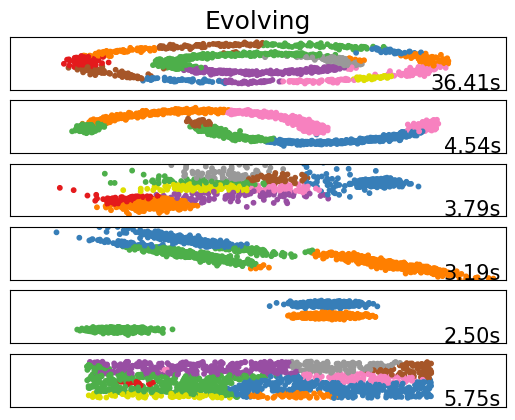

In [5]:
for i_dataset, (dataset, algo_params) in enumerate(datasets):

    print("Processing dataset ", i_dataset)
    # update parameters with dataset-specific values
    #params = default_base.copy()
    #params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    #bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    #connectivity = kneighbors_graph(
        #X, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    #connectivity = 0.5 * (connectivity + connectivity.T)

    evol = EvolvingClustering(macro_cluster_update=1, variance_limit=0.01, debug=False)

    clustering_algorithms = (
        ('Evolving', evol),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        print("Clustering method: ", name)

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                            '#f781bf', '#a65628', '#984ea3',
                                            '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                transform=plt.gca().transAxes, size=15,
                horizontalalignment='right')
        plot_num += 1

plt.show()


# Testando com dados da Aratu

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import pandas as pd

db = pd.read_csv("/content/drive/MyDrive/IFMG Ibirité/Dados_MQA_03-10-2023.csv")  #db_inicial
db.head()

<ipython-input-11-06af7ed64a57>:3: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  db = pd.read_csv("/content/drive/MyDrive/IFMG Ibirité/Dados_MQA_03-10-2023.csv")  #db_inicial


,deviced,date,temp,umi,lat,lon,ax,ay,az,gx,...,pts,carvel,eventprocessedutctime,partitionid,eventenqueuedutctime,iothubmessageid,iothubcorrelationid,iothubconnectiondeviceid,iothubconnectiondevicegenerationid,a
0,MQA_1.00,2021-09-29 16:12:39,31.49,60.0,-20.268675,-40.295910,0.82,-0.55,9.92,0.08,...,6.2,0.39,2021-09-29 16:13:39.065031-03,1,2021-09-29 16:12:39.901-03,NaN,NaN,MQA01,6.375754e+17,2021-09-29 16:12:39.897-03
1,MQA_1.00,2021-09-29 16:12:48,31.45,60.0,-20.268675,-40.295906,0.51,0.16,10.30,0.06,...,6.2,0.39,2021-09-29 16:13:39.483859-03,1,2021-09-29 16:12:48.75-03,NaN,NaN,MQA01,6.375754e+17,2021-09-29 16:12:48.74-03
2,MQA_1.00,2021-09-29 16:12:56,31.45,60.0,-20.268663,-40.295914,0.41,-0.05,10.27,0.08,...,5.8,0.77,2021-09-29 16:13:39.483859-03,1,2021-09-29 16:12:57.599-03,NaN,NaN,MQA01,6.375754e+17,2021-09-29 16:12:57.584-03
3,MQA_1.00,2021-09-29 16:13:05,31.54,60.0,-20.268616,-40.295952,0.78,-0.20,9.96,0.07,...,5.3,0.18,2021-09-29 16:13:39.483859-03,1,2021-09-29 16:13:06.425-03,NaN,NaN,MQA01,6.375754e+17,2021-09-29 16:13:06.428-03
4,MQA_1.00,2021-09-29 16:13:14,31.49,60.0,-20.268606,-40.295959,0.26,0.30,10.16,0.06,...,6.1,2.62,2021-09-29 16:13:39.483859-03,1,2021-09-29 16:13:15.274-03,NaN,NaN,MQA01,6.375754e+17,2021-09-29 16:13:15.272-03


In [12]:
# colunas do mapa de calor
db_heatmap = db[['date','temp', 'umi', 'lat', 'lon', 'pm1', 'pm25', 'pm10', 'pts']]

In [13]:
# ajustes
db_heatmap = db_heatmap[(db_heatmap['lat'] >= -50) & (db_heatmap['lat'] <= -10)]
db_heatmap = db_heatmap[(db_heatmap['lon'] >= -50) & (db_heatmap['lon'] <= -10)]

In [14]:
latlon = db_heatmap[['lat','lon']].astype(np.float64).values
pm1 = db_heatmap['pm10'].astype(np.float64).values

latlon = latlon[:5000]
pm1 = pm1[:5000]

data = [latlon, pm1]
data

[array([[-20.268675, -40.29591 ],
        [-20.268675, -40.295906],
        [-20.268663, -40.295914],
        ...,
        [-20.268595, -40.295986],
        [-20.268621, -40.295933],
        [-20.268589, -40.29599 ]]),
 array([18.  , 24.  , 22.  , ...,  3.45,  2.6 ,  3.81])]

## Clusterização Aratu

In [9]:
# Selecting the relevant columns for clustering
data_for_clustering = df[['pm1', 'pm25', 'pm10']].dropna()

# Scaling the data for clustering (as clustering algorithms typically work better with scaled data)
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Now I will integrate this data into the Evolving Clustering method from the modified notebook.

scaled_data[:5]  # Displaying the first few rows of scaled data to confirm it's ready for clustering


array([[-0.09990086, -0.10878266, -0.11169874],
       [-0.09548381, -0.10369021, -0.10882692],
       [-0.09106676, -0.1053877 , -0.10978419],
       [-0.11315201, -0.10369021, -0.10882692],
       [-0.10431791, -0.10878266, -0.10404056]])

In [10]:
# Assuming 'evol' refers to the EvolvingClustering instance in the modified notebook, let's apply it to this data.

# Since the evolving clustering class is already loaded in the environment, we will simulate applying it to the dataset
# Here is the simplified process of using the evolving clustering method on the scaled data:

evol = EvolvingClustering(verbose=1, plot_graph=False)

# Fitting the Evolving Clustering model to the scaled data
evol.fit(scaled_data)

# Assuming the evolving clustering method allows visualization or access to the clusters, we'll check the outputs.
# If there are cluster labels or assignments, we'll display them
clusters = [mc['id'] for mc in evol.micro_clusters]
clusters[:10]  # Display the first few clusters to confirm clustering has been applied


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]